## **Physics-Informed Neural Network (PINN) for the 1D Heat Equation**

This notebook demonstrates how to solve the 1D heat equation using a Physics-Informed Neural Network (PINN) implemented in PyTorch.  We will walk through the mathematical formulation, network architecture, training procedure, and visualization of results.

---

### 1. Problem Statement

We consider the 1D heat equation (diffusion equation):

$$
\frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2} = 0,
$$

for $x\in[-1,1]$, $t\in[0,1]$, with thermal diffusivity $\alpha>0$.

**Boundary conditions:**

* $u(-1,t)=0$,  $u(1,t)=0$  (Dirichlet walls)

**Initial condition:**

* $u(x,0)=\sin(\pi x)$

The analytic solution is known:

$$
 u(x,t) = e^{-\alpha \pi^2 t}\,\sin(\pi x).
$$



---

### 2. PINN Method Overview

A PINN approximates the solution $u(x,t)$ by a neural network $\hat{u}(x,t;\theta)$.  We enforce:

1. **PDE residual** at collocation points:
   $R(x,t) = \frac{\partial \hat{u}}{\partial t} - \alpha \frac{\partial^2 \hat{u}}{\partial x^2} \approx 0.$
2. **Boundary/Initial condition losses**:
   $\hat{u}(x,0) - \sin(\pi x) = 0, \quad \hat{u}(\pm1,t)=0.$

The total loss is the mean squared residual plus weighted condition errors.  We compute derivatives via automatic differentiation.

---


### 3. Network and Solver Classes
#### 3.1 UniversalDESolver

Encapsulates a feedforward network and PINN machinery:

* **`_build_network`**: constructs $\mathrm{Input}\to[\mathrm{Linear}\!+\mathrm{activation\_function}]^{L}\to\mathrm{Linear}$
* **`add_equation`**: register residual function and order
* **`add_condition`**: add BC/IC as weighted loss term
* **`compute_residual`**: uses `torch.autograd.grad` to compute first (and second) derivatives and evaluate $R(x,t)$
* **`compute_loss`**: samples domain points, computes residual loss + BC losses
* **`train_step`**: performs one Adam update on total PINN loss


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:

class UniversalDESolver(nn.Module):
    """
    Neural network-based solver for arbitrary differential equations (ODEs/PDEs).
    
    Uses automatic differentiation to compute equation residuals and physics-informed training.
    Can handle various equation types and boundary/initial conditions through a flexible interface.
    
    Key Features:
    -------------------------
    - Equation-agnostic: Works with any differential equation defined as a residual function
    - Automatic differentiation: Computes derivatives without symbolic math
    - Flexible conditions: Supports arbitrary boundary/initial conditions
    - Configurable architecture: Adjustable network depth and width
    
    Params:
    -------------------------
    - input_dim (int): Number of input dimensions (e.g., 2 for 1 space+ 1time)
    - hidden_dim (int): Number of neurons in hidden layers
    - num_layers (int): Number of hidden layers
    - output_dim (int): Number of output dimensions (1 for scalar fields)
    - activation_function (callable): The chosen non-linear transformation each node of the neural network
    """
    def __init__(self, 
                 input_dim: int = 2, 
                 hidden_dim: int = 64,
                 num_layers: int =4, 
                 output_dim: int = 1,
                 activation_function: callable = nn.Tanh):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.activation_function = activation_function  # must be one-to-one

        self.net = self._build_network()
        self.equation = None  # Will store equation specification
        self.conditions = []  # List of boundary/initial conditions
        self.domain = None  # Domain sampling object

    def _build_network(self):
        """
        Construct the neural network architecture.
        
        Returns:
        ----------------
        - feedforward neural network
        """
        layers = [nn.Linear(self.input_dim, self.hidden_dim), self.activation_function()]
        for _ in range(self.num_layers-1):
            layers += [nn.Linear(self.hidden_dim, self.hidden_dim), self.activation_function()]
        layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        return nn.Sequential(*layers)

    def add_equation(self, equation_dict):
        """
        Register the differential equation to solve.
        
        Params:
        --------------------
            equation_dict (dict): Contains equation specification:
                {
                    'function': (callable) defining the equation residual F(x, u, Du, D²u) = 0,  -> we wish to minimise this (along with boundary conditions)
                    'order': (int) (optional, highest derivative order for efficiency hints),
                    'parameters': (dict) (optional, equation-specific parameters)
                }
                
        Example for heat equation: 
            {'function': heat_residual, 'order': 2}
        """
        self.equation = equation_dict

    def add_condition(self, condition_dict):
        """
        Add boundary/initial condition constraint.
        
        Params:
        ----------------
            condition_dict (dict): Contains condition specification:
                {
                    'type': str label ('initial'/'boundary'/etc.),
                    'function': callable defining condition u(x) = target_value,
                    'points': tensor of evaluation points,
                    'weight': float (relative loss weight, default=1.0)
                }
        """
        self.conditions.append(condition_dict)

    def forward(self, x):
        """Network forward pass - predicts solution u(x,t)"""
        return self.net(x)

    def compute_residual(self, inputs: torch.Tensor) -> torch.Tensor:
        """
        Compute equation residual using automatic differentiation.
        
        Automatically computes required derivatives up to second order using PyTorch autograd.
        
        Params:
        ---------------
        inputs (torch.Tensor): Input coordinates (batch_size x input_dim)
            
        Returns:
        ---------------
        Residual values (torch.Tensor) (batch_size x 1) where F(x, u, Du, D²u) should = 0
        """
        inputs.requires_grad_(True)  # Enable gradient tracking
        u = self(inputs)  # Forward pass of network
        
        # Compute first derivatives Du = (du/dx1, du/dx2, ...) (partital derivatives)
        du = torch.autograd.grad(
            u, 
            inputs, 
            grad_outputs=torch.ones_like(u),  # d(output)/d(output) = 1
            create_graph=True  # Retain graph for higher-order derivatives
        )[0]
        
        # Compute second derivatives if needed (for second-order equations)
        if self.equation.get('order', 1) > 1:
            # Compute D²u = (d²u/dx1², d²u/dx1dx2, ...) (partial derivatives)
            d2u = torch.autograd.grad(
                du, 
                inputs,
                grad_outputs=torch.ones_like(du),
                create_graph=True
            )[0]
        else:
            d2u = None
            
        # Evaluate equation residual: F(x, u, Du, D²u)
        return self.equation['function'](inputs, u, du, d2u)

    def compute_loss(self, batch_size: int = 512) -> torch.Tensor:
        """
        Calculate total loss combining equation residual and boundary conditions.
        - we implement the boundary conditions to prevent the function (neural network gradients) vanish
        
        Loss = MSE(residual) + SUM [weight * MSE(condition)]
        
        Params:
        --------------
        - batch_size (int): Number of domain points to sample
            
        Returns:
        -------------
        - Total loss tensor
        """
        # Sample points from problem domain
        domain_points = self.domain.sample(batch_size)
        
        # Equation residual loss (physics constraint)
        residual = self.compute_residual(domain_points)
        eq_loss = torch.mean(residual**2)
        
        # Boundary/initial condition losses
        cond_loss = torch.tensor(0.0, device=residual.device)
        for cond in self.conditions:
            pred = self(cond['points'])
            target = cond['function'](cond['points'])
            weight = cond.get('weight', 1.0)
            cond_loss += weight * torch.mean((pred - target)**2)
            
        return eq_loss + cond_loss

    def train_step(self, optimizer: torch.optim.Optimizer, batch_size: int = 512) -> float:
        """
        Perform one training iteration.
        
        Param:
        ------------
        - optimizer: Optimization algorithm 
        - batch_size: Number of domain points to sample
            
        Returns:
        ------------
        - Loss value (float)
        """
        optimizer.zero_grad()
        loss = self.compute_loss(batch_size)
        loss.backward()
        optimizer.step()
        return loss.item()



#### 3.2 DomainSampler

Generates random collocation points:

In [3]:
class DomainSampler:
    """
    Handles domain and boundary sampling for differential equation problems.
    
    Params:
    ------------------
    - ranges (dict): Dictionary specifying domain ranges for each dimension
            Example: {'x': [-1, 1], 't': [0, 1]}
    """
    def __init__(self, ranges: dict):
        self.ranges = ranges
        self.dim_names = list(ranges.keys())
        
    def sample(self, n_points: __init__):
        """
        Generate random points within the domain. (could perform monte carlo sampling for robust convergence)
        
        Params:
        --------------
        - n_points (int): Number of points to sample
            
        Returns:
        ---------------
        - Tensor of shape (n_points, input_dim) with uniformly sampled points
        """
        points = []
        for dim in self.dim_names:
            low, high = self.ranges[dim]
            points.append(torch.rand(n_points, 1) * (high - low) + low)
        return torch.cat(points, dim=1)

    def sample_boundary(self, dim, value: int, n_points: int):
        """
        Sample points on a specific boundary hyperplane.
        
        Params:
        ------------
        - dim: Dimension to fix at boundary value
        - value: Fixed value for the specified dimension
        - n_points: Number of points to sample
            
        Returns:
        --------------
        - Tensor of shape (n_points, input_dim) with fixed dimension
        """
        points = []
        for d in self.dim_names:
            if d == dim:
                points.append(torch.full((n_points, 1), value))
            else:
                low, high = self.ranges[d]
                points.append(torch.rand(n_points, 1) * (high - low) + low)
        return torch.cat(points, dim=1)



---

### 4. Defining the Heat Residual

In [4]:

def heat_residual(inputs: torch.Tensor, 
                  u: torch.Tensor, 
                  du: torch.Tensor,
                  d2u: torch.Tensor,
                  alpha: float = 0.1) -> torch.Tensor:
    """
    Compute heat equation residual: du/dt - alpha·d²u/dx² = 0.
    
    Params:
    ----------------
    - inputs: Tensor of shape (batch, 2) containing (x, t) pairs
    - u: Solution u(x,t) - shape (batch, 1)
    - du: First derivatives [du/dx, du/dt] - shape (batch, 2)
    - d2u: Second derivatives [d²u/dx², d²u/dxdt, ...] - shape (batch, 2)
    - alpha (float): thermal diffusivity
    
    Returns:
        Residual values - shape (batch, 1)
    """
    # Unpack first derivatives
    du_dx = du[..., 0:1]  # Spatial derivative
    du_dt = du[..., 1:2]  # Temporal derivative
    
    # Compute second spatial derivative if needed
    if d2u is None:
        # Compute ∂²u/∂x² using automatic differentiation
        d2u_dx2 = torch.autograd.grad(
            du_dx, 
            inputs,
            grad_outputs=torch.ones_like(du_dx),
            create_graph=True
        )[0][..., 0:1]
    else:
        # Use precomputed second derivative (∂²u/∂x²)
        d2u_dx2 = d2u[..., 0:1]
    
    # Heat equation residual: ∂u/∂t - α·∂²u/∂x²
    return du_dt - alpha * d2u_dx2


---

### 5. Setup and Training

In [5]:
# Set up problem domain (space x in [-1, 1], time t in [0, 1])
domain = DomainSampler({'x': [-1, 1], 't': [0, 1]})

# Create solver instance
solver = UniversalDESolver(input_dim=2)
solver.add_equation({
    'function': heat_residual,
    'order': 2  # Indicates second-order equation
})

# Add initial condition (t=0): u(x,0) = sin(πx)
initial_points = domain.sample_boundary('t', 0, 1000)
solver.add_condition({
    'type': 'initial',
    'function': lambda pts: torch.sin(np.pi * pts[..., 0:1]),
    'points': initial_points,
    'weight': 1.0
})

# Add boundary conditions: u(-1,t) = u(1,t) = 0
for x_val in [-1, 1]:
    boundary_points = domain.sample_boundary('x', x_val, 500)
    solver.add_condition({
        'type': 'boundary',
        'function': lambda pts: torch.zeros_like(pts[..., 0:1]),
        'points': boundary_points,
        'weight': 1.0
    })

# Configure training
optimizer = torch.optim.Adam(solver.parameters(), lr=0.001)
solver.domain = domain  # Attach domain sampler to solver

# Training loop with loss tracking
losses = []  # Store loss history
for epoch in range(20000):
    loss = solver.train_step(optimizer)
    losses.append(loss)
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.5f}")

Epoch 0, Loss: 0.66662
Epoch 1000, Loss: 0.00109
Epoch 2000, Loss: 0.00059
Epoch 3000, Loss: 0.00062
Epoch 4000, Loss: 0.00059
Epoch 5000, Loss: 0.00034
Epoch 6000, Loss: 0.00119
Epoch 7000, Loss: 0.00005
Epoch 8000, Loss: 0.00024
Epoch 9000, Loss: 0.00006
Epoch 10000, Loss: 0.00033
Epoch 11000, Loss: 0.00009
Epoch 12000, Loss: 0.00014
Epoch 13000, Loss: 0.00002
Epoch 14000, Loss: 0.00002
Epoch 15000, Loss: 0.00019
Epoch 16000, Loss: 0.00001
Epoch 17000, Loss: 0.00003
Epoch 18000, Loss: 0.00001
Epoch 19000, Loss: 0.00002


---

### 6. Analytical Solution and Visualization

The analytic solution is:

$$
    u(x,t)=e^{-\alpha \pi^2 t} \sin(\pi x).
$$

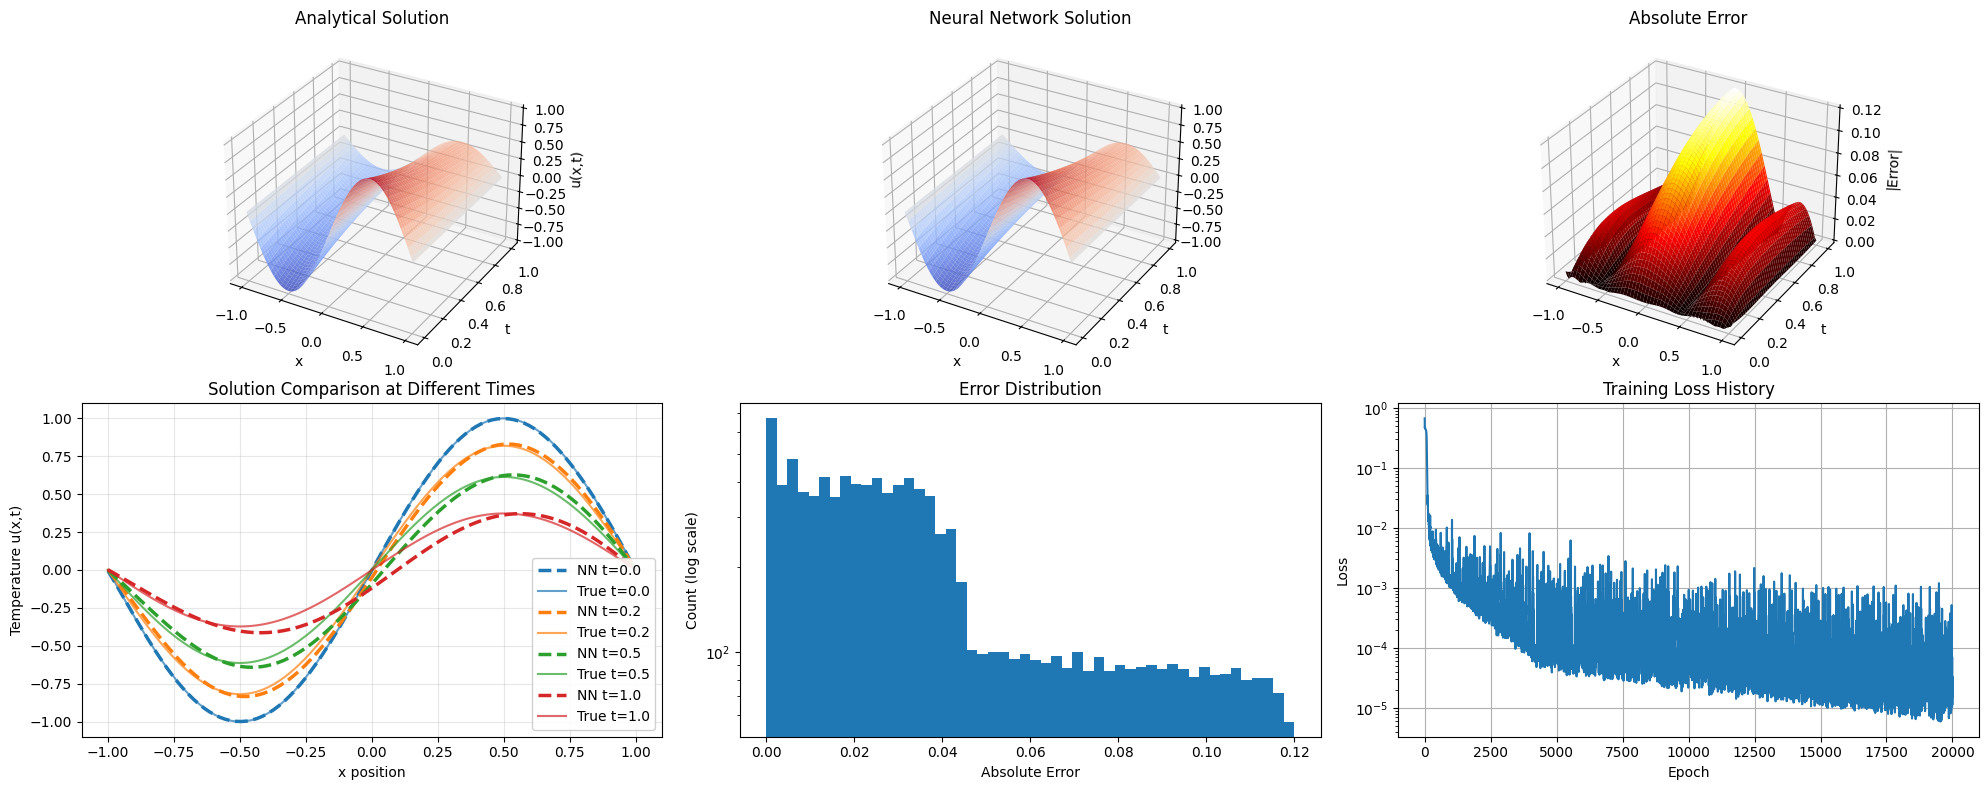

In [6]:
def analytical_solution(x: np.ndarray, t: np.ndarray, alpha: float = 0.1) -> np.ndarray:
    """
    Analytical solution for heat equation: u(x,t) = sin(πx)exp(-alpha*π²t)
    
    Args:
        x: Spatial coordinates
        t: Temporal coordinates
        alpha (float): Thermal Diffusivity
        
    Returns:
        Solution array with same shape as inputs
    """
    return np.sin(np.pi * x) * np.exp(-alpha * (np.pi**2) * t)

# Create test grid for visualization
x_test = np.linspace(-1, 1, 100)
t_test = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_test, t_test)  # 100x100 grid

# Convert to tensor for network prediction
test_inputs = torch.tensor(np.stack([X.ravel(), T.ravel()], axis=1), 
                           dtype=torch.float32)

# Compute solutions
with torch.no_grad():
    # Neural network predictions
    nn_pred = solver(test_inputs).numpy().reshape(X.shape)
    
    # Analytical solution
    true_sol = analytical_solution(X, T)

# Create visualization figure
plt.figure(figsize=(20, 8))

# 1. Solution Comparison Surface Plot
ax1 = plt.subplot(231, projection='3d')
ax1.plot_surface(X, T, true_sol, cmap='coolwarm', alpha=0.8)
ax1.set_title('Analytical Solution')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('u(x,t)')

ax2 = plt.subplot(232, projection='3d')
ax2.plot_surface(X, T, nn_pred, cmap='coolwarm', alpha=0.8)
ax2.set_title('Neural Network Solution')
ax2.set_xlabel('x')
ax2.set_ylabel('t')

# 2. Absolute Error Surface
ax3 = plt.subplot(233, projection='3d')
ax3.plot_surface(X, T, np.abs(nn_pred - true_sol), cmap='hot')
ax3.set_title('Absolute Error')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('|Error|')

# 3. Time Snapshots Comparison
ax4 = plt.subplot(234)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colorblind-friendly palette

for t_val, color in zip([0.0, 0.2, 0.5, 1.0], colors):
    # Find nearest time index
    t_idx = np.abs(t_test - t_val).argmin()
    
    # Plot neural network prediction
    plt.plot(X[t_idx, :], nn_pred[t_idx, :], '--', lw=2.5, 
             color=color, label=f'NN t={t_val:.1f}')
    
    # Plot analytical solution
    plt.plot(X[t_idx, :], true_sol[t_idx, :], '-', lw=1.5, 
             color=color, alpha=0.7, label=f'True t={t_val:.1f}')

plt.title('Solution Comparison at Different Times')
plt.xlabel('x position')
plt.ylabel('Temperature u(x,t)')
plt.grid(alpha=0.3)
plt.legend(framealpha=0.9)

# 4. Error Distribution Histogram
ax5 = plt.subplot(235)
error = np.abs(nn_pred - true_sol).ravel()
plt.hist(error, bins=50, log=True)
plt.title('Error Distribution')
plt.xlabel('Absolute Error')
plt.ylabel('Count (log scale)')

# 5. Training Loss History
ax6 = plt.subplot(236)
plt.semilogy(losses)
plt.title('Training Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

---

### 7. Summary and Next Steps

* We built a generic `UniversalDESolver` that uses autodiff for residuals.
* Solved a 1D heat equation and validated against the analytic solution.
* **Next:** 
    - extend to 2D/3D PDEs
    - transform PDEs to unit hyperspheres
    - implement monte carlo sampling to cover these hyperspheres intensly
    - implement korobov transforms on the transforms unit hypersphere PDE for stronger convergence properites
    - apply the fitted heat equation under the same transforms as seen when deriving blackscholes, see if the fitted neural network (heat equation diff nn) can be used to model black scholes (heat equation diff nn -> black scholes diff nn ? :/)
